In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [2]:
%%R
library(phyloseq)
library(doParallel)
library(ggplot2)
library(vegan)
library(RColorBrewer)
library(plyr)
library(gridExtra)

Loading required package: foreach
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1
Loading required package: grid


In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq_snorm = transform_sample_counts(physeq, function(x) x / sum(x))

In [5]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, days), all at once
# I create a list of the variables I want to run the ordination by
days = list(Day1=0, Day12=1, Day82=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Day == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    p.nmds$Samples = rownames(p.nmds)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.days = ldply(days, ord)
ord.NMDS.days = ord.NMDS.days[,2:9]

Run 0 stress 0.1368866 
Run 1 stress 0.1368896 
... procrustes: rmse 0.0008605471  max resid 0.004529016 
*** Solution reached
Run 0 stress 0.05872817 
Run 1 stress 0.04999936 
... New best solution
... procrustes: rmse 0.03490803  max resid 0.1086016 
Run 2 stress 0.05008779 
... procrustes: rmse 0.00250275  max resid 0.01248839 
Run 3 stress 0.05346144 
Run 4 stress 0.05160509 
Run 5 stress 0.05181835 
Run 6 stress 0.05211524 
Run 7 stress 0.05214526 
Run 8 stress 0.04999901 
... New best solution
... procrustes: rmse 0.0001624062  max resid 0.0008127388 
*** Solution reached
Run 0 stress 0.1204313 
Run 1 stress 0.1353678 
Run 2 stress 0.1204313 
... New best solution
... procrustes: rmse 2.214032e-05  max resid 0.0001161534 
*** Solution reached


In [6]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, amendments), all at once
# I create a list of the variables I want to run the ordination by
amdmts = list(Soil=0, PyOM=1, Stover=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Amdmt == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    p.nmds$Samples = rownames(p.nmds)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.amdmts = ldply(amdmts, ord)
ord.NMDS.amdmts = ord.NMDS.amdmts[,2:9]

Run 0 stress 0.1548713 
Run 1 stress 0.154874 
... procrustes: rmse 0.0006616869  max resid 0.002759642 
*** Solution reached
Run 0 stress 0.1602812 
Run 1 stress 0.1518263 
... New best solution
... procrustes: rmse 0.05003877  max resid 0.1917073 
Run 2 stress 0.1738361 
Run 3 stress 0.1588671 
Run 4 stress 0.1757598 
Run 5 stress 0.4025131 
Run 6 stress 0.1543728 
Run 7 stress 0.1518267 
... procrustes: rmse 0.0001004775  max resid 0.0005048799 
*** Solution reached
Run 0 stress 0.05172939 
Run 1 stress 0.05429901 
Run 2 stress 0.05170456 
... New best solution
... procrustes: rmse 0.002713112  max resid 0.008947516 
*** Solution reached


In [7]:
%%R
# Computing the weighted unifrac distance matrix and NMDS in parallel
registerDoParallel(cores=10)
ord.NMDS.full = ordinate(physeq_snorm, method = "NMDS", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
NMDS.full = plot_ordination(physeq_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

Run 0 stress 0.09070361 
Run 1 stress 0.09059325 
... New best solution
... procrustes: rmse 0.008105438  max resid 0.05469103 
Run 2 stress 0.09876882 
Run 3 stress 0.0946662 
Run 4 stress 0.0960184 
Run 5 stress 0.09628066 
Run 6 stress 0.09069865 
... procrustes: rmse 0.007820323  max resid 0.05397241 
Run 7 stress 0.09197972 
Run 8 stress 0.09672714 
Run 9 stress 0.09319124 
Run 10 stress 0.09567774 
Run 11 stress 0.09437633 
Run 12 stress 0.0945853 
Run 13 stress 0.09670908 
Run 14 stress 0.09463421 
Run 15 stress 0.09437425 
Run 16 stress 0.09252582 
Run 17 stress 0.09271948 
Run 18 stress 0.09379129 
Run 19 stress 0.0990038 
Run 20 stress 0.097494 


In [8]:
%%R
head(ord.NMDS.amdmts)

          NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day Samples
1 -0.0008776365 -0.022515767      0       00     0  A   0    S026
2 -0.0215862961 -0.019270558      1       00     0  C   0    S023
3  0.0189260045  0.010958198      0       20     0  A   2    S201
4  0.0090235377  0.009436904      1       10     0  C   1    S133
5  0.0325616995  0.001773158      1       10     0  C   1    S103
6 -0.0044299839 -0.004950562      1       10     0  C   1    S108


In [9]:
%%R
simple <- ord.NMDS.days
full <- NMDS.full
simple$ord <- "By day"
full$ord <- "Full"
NMDS.days<-rbind(simple, full)
head(NMDS.days)

        NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day Samples    ord
1 -0.01348451 -0.022198727      1       01     1  D   0    S009 By day
2  0.01525270 -0.024067162      0       00     0  A   0    S026 By day
3 -0.01965365 -0.030501533      1       00     0  C   0    S023 By day
4 -0.02063123  0.003613820      0       01     1  B   0    S012 By day
5 -0.08618248  0.044703282      0       00     0  A   0    S031 By day
6 -0.02919205  0.006132981      1       00     0  C   0    S013 By day


In [10]:
%%R
simple <- ord.NMDS.amdmts
full <- NMDS.full
simple$ord <- "By amendment"
full$ord <- "Full"
NMDS.amdmts<-rbind(simple, full)
dim(NMDS.amdmts)

[1] 238   9


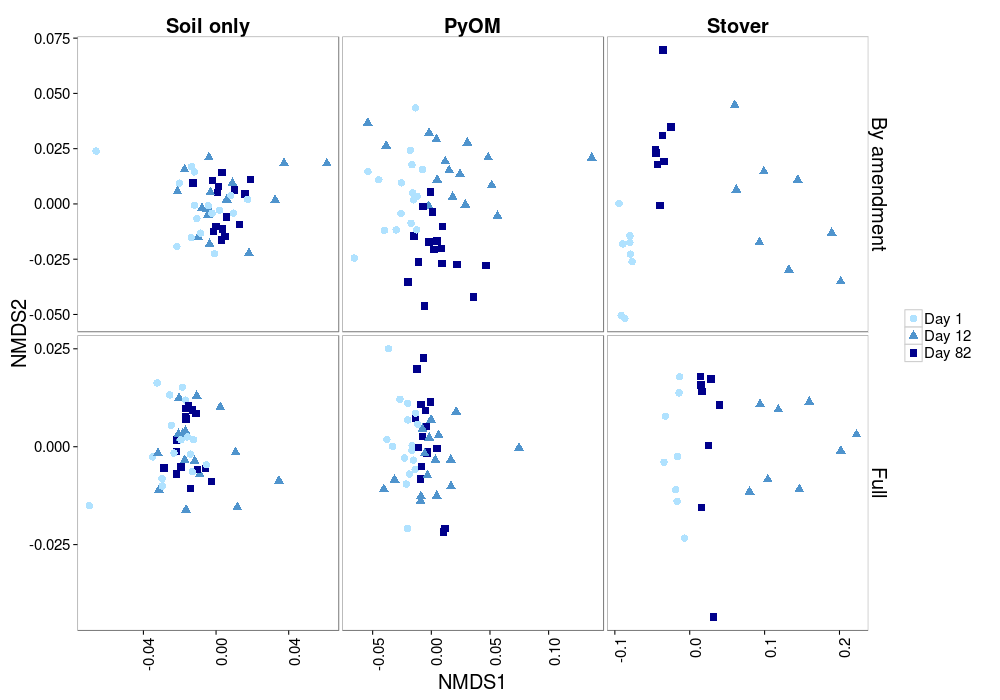

In [20]:
%%R -h 700 -w 1000
D <- NMDS.amdmts
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$ord = factor(D$ord, levels=c("Full", "By amendment"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
#D$Strip1 = paste(D$AmdmtName)
D$Strip2 = paste(D$ord)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 15, angle = 90, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 20),
              axis.text.y = element_text(size=15),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 15))

# Displays the plot object
p = p + facet_grid(~Strip2~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
#p = p + facet_wrap(~AmdmtName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Amendments
plot.amdmts = p
p

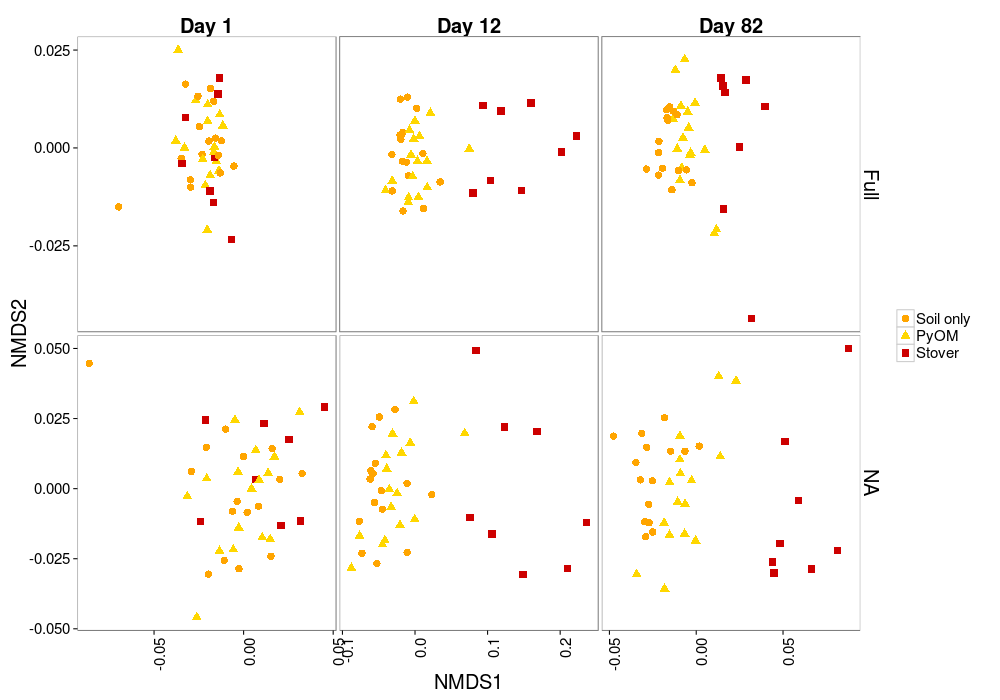

In [21]:
%%R -h 700 -w 1000
D <- NMDS.days
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$ord = factor(D$ord, levels=c("Full", "By day"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))
D$Strip2 = paste(D$ord)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 15, angle = 90, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 20),
              axis.text.y = element_text(size=15),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 15))

# Displays the plot object
p = p + facet_grid(~Strip2~DayName, scales = "free")
# The axis scales could be all optimized individually
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Amendments
plot.days = p
p

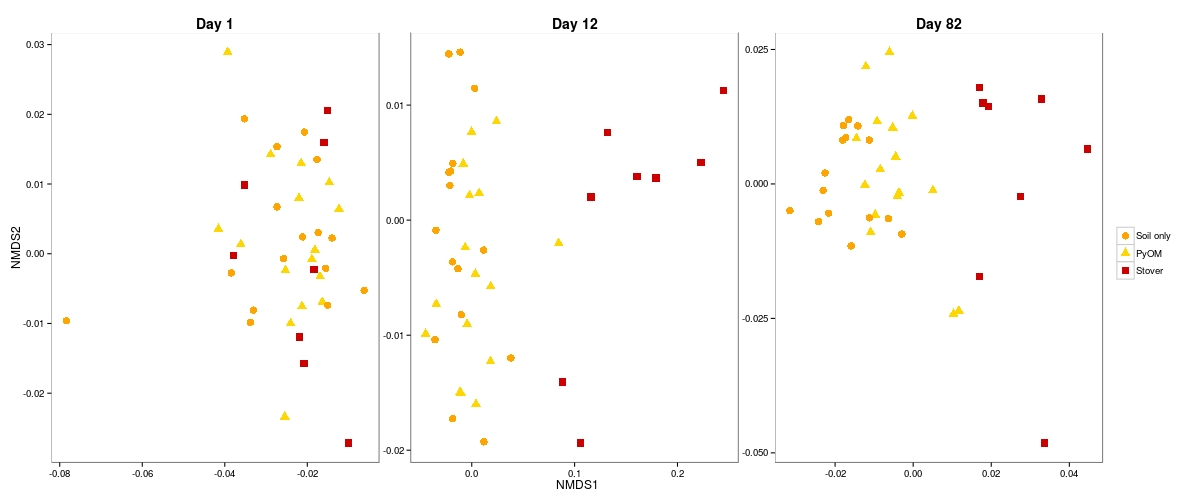

In [60]:
%%R -h 500 -w 1200
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales = "free")
# The axis scales could be all optimized individually
#p = p + facet_wrap(~DayName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byDay = p
p

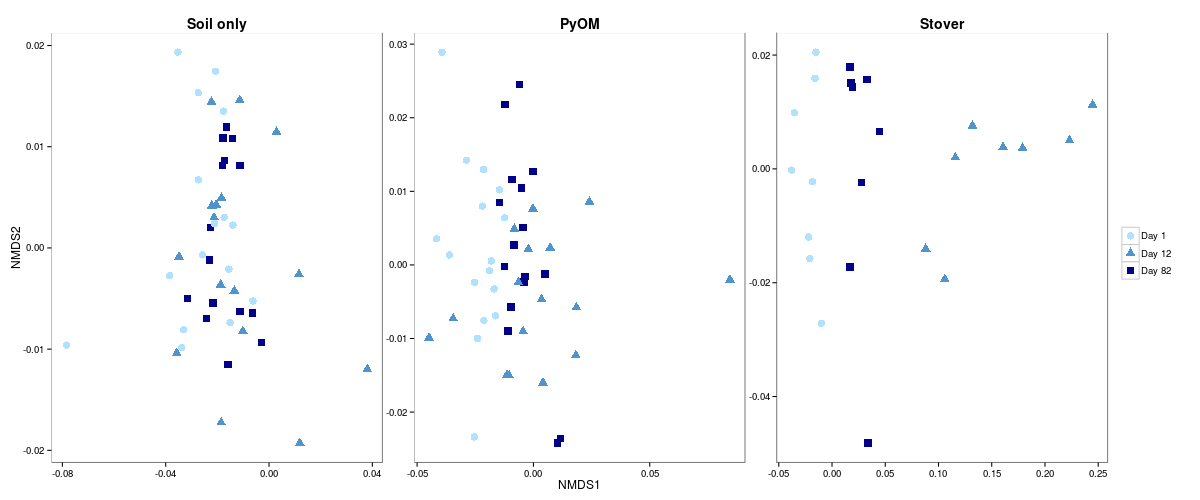

In [56]:
%%R -h 500 -w 1200
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~AmdmtName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byAmdmt = p
p

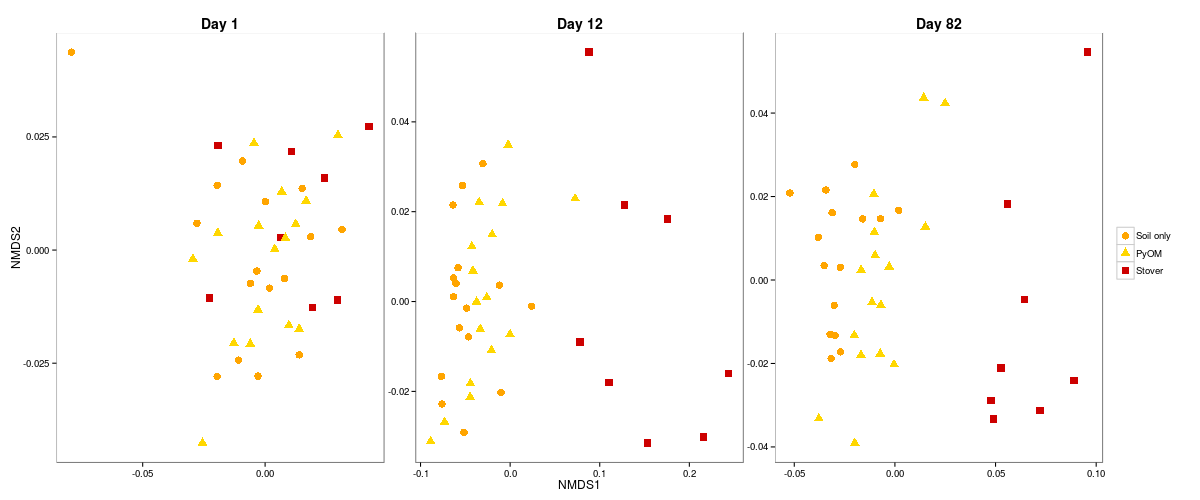

In [59]:
%%R -h 500 -w 1200
D <- ord.NMDS.days
# Sets the relevant ordination

colnames(D)[2:3]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales = "free")
# The axis scales could be all optimized individually
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.byDay = p
p

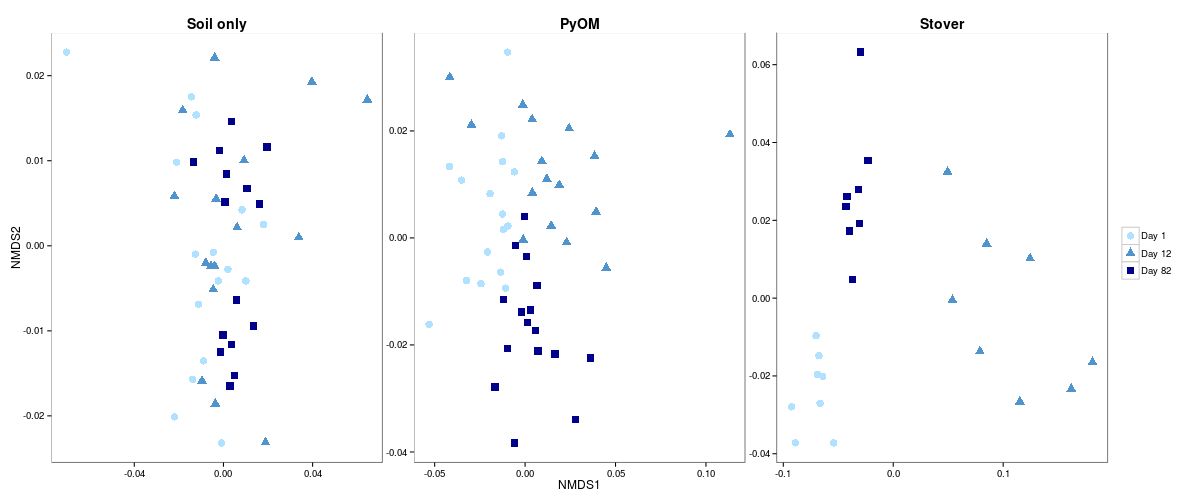

In [47]:
%%R -h 500 -w 1200
D <- ord.NMDS.amdmts
# Sets the relevant ordination

colnames(D)[2:3]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~strip)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.byAmdmt = p
p

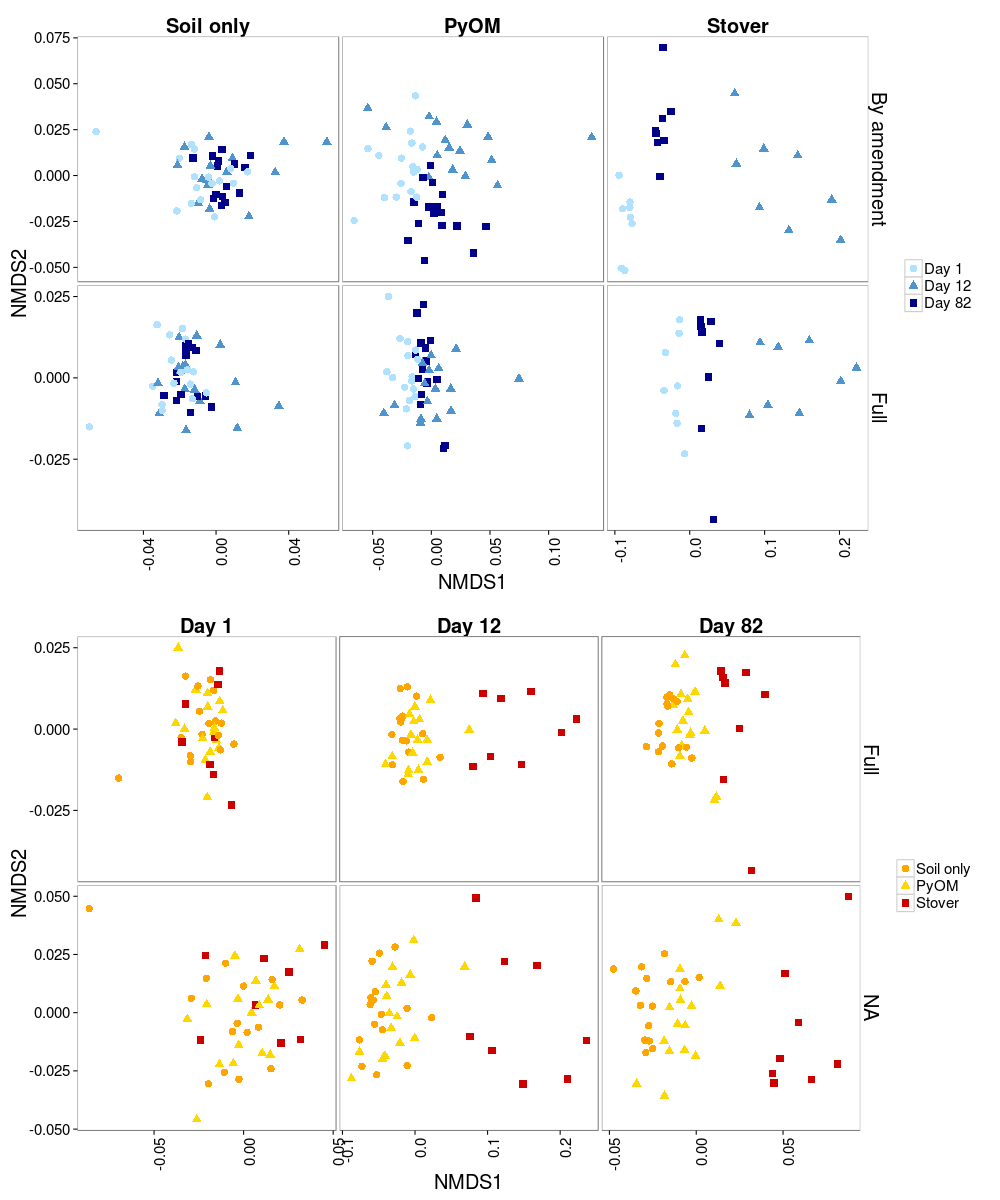

In [22]:
%%R -h 1200 -w 1000
grid.arrange(plot.amdmts, plot.days, nrow=2)